# Spam Email Detection using Naive Bayes

This project uses a Naive Bayes classifier to detect spam emails. We will preprocess the email dataset, train the model, and evaluate its performance.
1. **Load and explore the dataset.**
2. **Preprocess the data.**
3. **Train a Naive Bayes model.**
4. **Evaluate the model's performance.**
5. **Save the Model**
6. **Make predictions with sample inputs.**

In [12]:
!pip install pandas scikit-learn matplotlib seaborn wordcloud joblib

## Load and Explore the Dataset

In [13]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/phantristan/Spam-Email-Detection/main/src/data/email.csv'
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Preprocess the data

In [14]:
# Normalize column names to lowercase
data.columns = data.columns.str.lower()

# Select and rename relevant columns
data = data[['category', 'message']]
data.columns = ['label', 'message']

# Drop rows with missing values
data = data.dropna(subset=['label', 'message'])  # Drop rows with missing labels or messages

# Map labels to binary values (ham = 0, spam = 1)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Drop rows with any remaining NaN values after mapping
data = data.dropna(subset=['label'])  # Ensure there are no NaN values in 'label'

# Verify the cleaned data
print(data.isnull().sum())  # Should print 0 for both 'label' and 'message'
data.head()

label      0
message    0
dtype: int64


,label,message
0,0.0,"Go until jurong point, crazy.. Available only ..."
1,0.0,Ok lar... Joking wif u oni...
2,1.0,Free entry in 2 a wkly comp to win FA Cup fina...
3,0.0,U dun say so early hor... U c already then say...
4,0.0,"Nah I don't think he goes to usf, he lives aro..."


### _Most Common Words_
Here's a bar chart showing the most common words for spam emails (in the dataset)

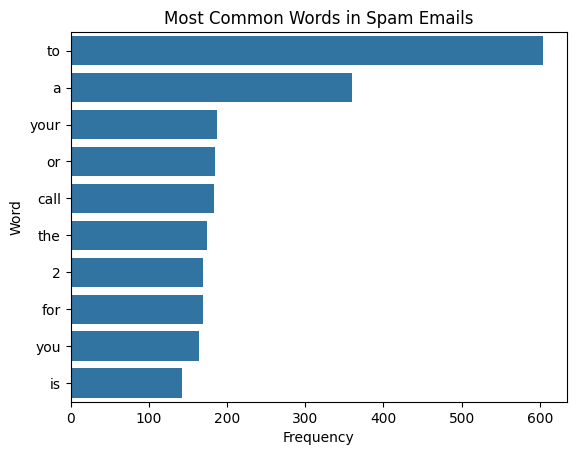

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Get the most common words from spam emails
spam_words = ' '.join(data[data['label'] == 1]['message']).split()
spam_word_freq = Counter(spam_words).most_common(10)

# Convert to DataFrame for visualization
spam_word_df = pd.DataFrame(spam_word_freq, columns=['Word', 'Frequency'])

# Plot the most frequent words in spam emails
sns.barplot(x='Frequency', y='Word', data=spam_word_df)
plt.title('Most Common Words in Spam Emails')
plt.show()

### _Visualize Word Frequencies_

Here's a word cloud to visualize the most common words in spam emails in a broader sense.

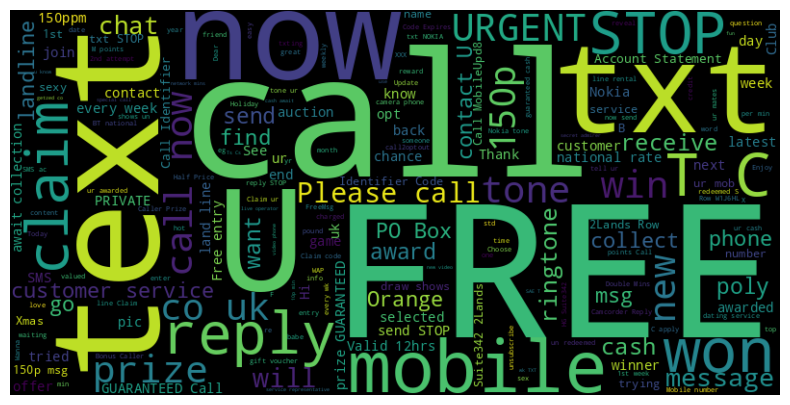

In [16]:
from wordcloud import WordCloud

# Generate a word cloud for spam emails
spam_words = ' '.join(data[data['label'] == 1]['message'])
spam_wordcloud = WordCloud(width=800, height=400).generate(spam_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### _Class Distribution_
Here's a bar chart to show how many spam and non-spam emails are in the dataset.

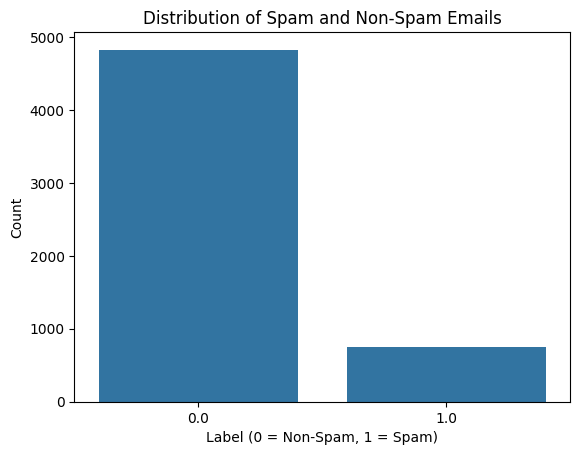

In [17]:
# Plot the distribution of spam(1) vs. non-spam (0) emails
sns.countplot(x='label', data=data)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.xlabel('Label (0 = Non-Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()

In [18]:
# Split the dataset into Training and Test Sets
from sklearn.model_selection import train_test_split

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    data['message'], data['label'], test_size=0.3, random_state=42
)

In [19]:
# Convert text data into numerical features using TF_IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)

### _TF-IDF Feature Importance (Word Contributions)_
This gives us the top words with the highest TF-IDF scores to show us which words are most important for the model.

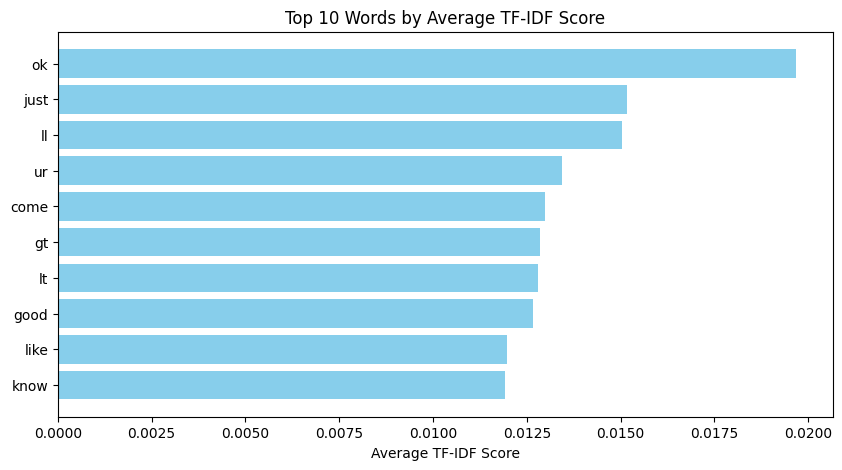

In [20]:
import matplotlib.pyplot as plt

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate the average TF-IDF score for each feature across all documents
tfidf_scores = X_train_tfidf.mean(axis=0).A1  # Convert sparse matrix to array

# Create a DataFrame to store the feature names and their corresponding scores
tfidf_df = pd.DataFrame({'Word': feature_names, 'Score': tfidf_scores})

# Sort the DataFrame by score in descending order and select the top 10 words
top_words_df = tfidf_df.sort_values(by='Score', ascending=False).head(10)

# Plot the top 10 words by their average TF-IDF score
plt.figure(figsize=(10, 5))
plt.barh(top_words_df['Word'], top_words_df['Score'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest score on top
plt.title('Top 10 Words by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.show()

## Train the Naive Bayes Model

In [21]:
from sklearn.naive_bayes import MultinomialNB

#initialize and train the model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

## Evaluate the Model

In [22]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Extract key metrics from the report
precision_spam = report['1.0']['precision']
recall_spam = report['1.0']['recall']
f1_score_spam = report['1.0']['f1-score']
accuracy = report['accuracy']

# Display Metrics in summary table

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the report as a table in the notebook
report_summary = report_df[['precision', 'recall', 'f1-score', 'support']]
report_summary

,precision,recall,f1-score,support
0.0,0.979675,0.998619,0.989056,1448.000000
1.0,0.989796,0.866071,0.923810,224.000000
accuracy,0.980861,0.980861,0.980861,0.980861
macro avg,0.984735,0.932345,0.956433,1672.000000
weighted avg,0.981031,0.980861,0.980315,1672.000000


### _Confusion Matrix_
Here is a heatmap to help visualize the performance of the model through the number of true positives, true negatives, false positives, and false negatives.

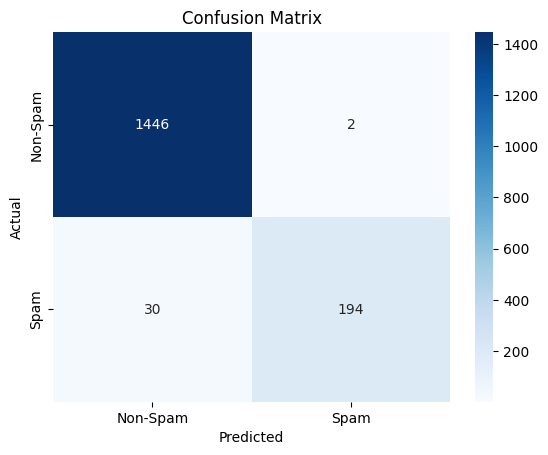

In [23]:
from sklearn.metrics import confusion_matrix

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save the Model and Vectorizer

In [24]:
import os
import joblib

# Ensure the 'models' directory exists
os.makedirs('models', exist_ok=True)

joblib.dump(model, 'models/spam_detector_model.pkl')
joblib.dump(vectorizer, 'models/vectorizer.pkl')

['models/vectorizer.pkl']

## Make predictions with sample inputs

In [25]:
# Load the model and vectorizer
model = joblib.load('models/spam_detector_model.pkl')
vectorizer = joblib.load('models/vectorizer.pkl')

# Function to predict if an email is spam or not
def predict_email(email):
    email_tfidf = vectorizer.transform([email])
    prediction = model.predict(email_tfidf)
    return 'Spam' if prediction[0] == 1 else 'Not Spam'

# Test the function
print("Welcome to the Spam Email Detection CLI!")
while True:
    email = input("\nEnter the email content (or type 'exit' to quit): ")
    if email.lower() == 'exit':
        break
    print("Prediction:", predict_email(email))

# Examples for the CLI if needed:

#    Scam -
#        Congratulations! You've won $1,000,000 in our lucky draw. Click here to claim your prize: http://scam-link.com
#        Dear Customer,
#            Your account has been temporarily suspended. Please verify your information immediately by clicking this link: http://phishing-bank.com
#            Thank you for your cooperation.
#        Earn $500 per day working from home! No experience required. Just click here to start earning today: http://easy-money.com
#
#    Non-Scam -
#        Hi John,
#            Please find attached the meeting agenda for tomorrow’s project kickoff at 10 AM. Let me know if you need anything else.
#            Best regards,
#            Sarah
#        Hi Mark,
#            Thank you for your order! Your package will arrive within 3-5 business days.
#            Tracking Number: 12345XYZ
#            Thank you for shopping with us!
#            Best regards,
#            The Store Team

Welcome to the Spam Email Detection CLI!

Enter the email content (or type 'exit' to quit):   Congratulations! You've won $1,000,000 in our lucky draw. Click here to claim your prize: http://scam-link.com
Prediction: Spam

Enter the email content (or type 'exit' to quit):  Dear Customer,   #            Your account has been temporarily suspended. Please verify your information immediately by clicking this link: http://phishing-bank.com   #            Thank you for your cooperation.
Prediction: Spam

Enter the email content (or type 'exit' to quit):  Hi John,   #            Please find attached the meeting agenda for tomorrow’s project kickoff at 10 AM. Let me know if you need anything else.   #            Best regards,   #            Sarah
Prediction: Not Spam

Enter the email content (or type 'exit' to quit): Hi Mark,   #            Thank you for your order! Your package will arrive within 3-5 business days.   #            Tracking Number: 12345XYZ   #            Thank you for shoppin

## Conclusion

The Naive Bayes model achieved the following results:

- **Precision (Spam):** 0.99
- **Recall (Spam):** 0.87
- **F1-Score (Spam):** 0.93
- **Accuracy:** 0.98